<a href="https://colab.research.google.com/github/Coolguy4123/News-Classifier-NLP/blob/main/News_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter

import torch

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

#DATA INFO

In [ ]:
news_data.DESCR

'.. _20newsgroups_dataset:\n\nThe 20 newsgroups text dataset\n------------------------------\n\nThe 20 newsgroups dataset comprises around 18000 newsgroups posts on\n20 topics split in two subsets: one for training (or development)\nand the other one for testing (or for performance evaluation). The split\nbetween the train and test set is based upon a messages posted before\nand after a specific date.\n\nThis module contains two loaders. The first one,\n:func:`sklearn.datasets.fetch_20newsgroups`,\nreturns a list of the raw texts that can be fed to text feature\nextractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`\nwith custom parameters so as to extract feature vectors.\nThe second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,\nreturns ready-to-use features, i.e., it is not necessary to use a feature\nextractor.\n\n**Data Set Characteristics:**\n\n=================   ==========\nClasses                     20\nSamples total            18846\nDime

In [ ]:
%%capture
news_data.data

In [ ]:
news_data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
print("CATEGORIES AND DISTRIBUTION")
category_counts = Counter(news_data.target)
df = pd.DataFrame(
    [(i, news_data.target_names[i], category_counts.get(i, 0))
     for i in range(len(news_data.target_names))],
    columns=["id", "category", "count"]
)

df

CATEGORIES AND DISTRIBUTION


,id,category,count
0,0,alt.atheism,799
1,1,comp.graphics,973
2,2,comp.os.ms-windows.misc,985
3,3,comp.sys.ibm.pc.hardware,982
4,4,comp.sys.mac.hardware,963
5,5,comp.windows.x,988
6,6,misc.forsale,975
7,7,rec.autos,990
8,8,rec.motorcycles,996
9,9,rec.sport.baseball,994


In [ ]:
doc_lengths = [len(doc.split()) for doc in news_data.data]
print("\n=== DOCUMENT LENGTH STATISTICS ===")
print(f"Mean length: {np.mean(doc_lengths):.2f} words")
print(f"Median length: {np.median(doc_lengths):.2f} words")
print(f"Min length: {np.min(doc_lengths)} words")
print(f"Max length: {np.max(doc_lengths)} words")


=== DOCUMENT LENGTH STATISTICS ===
Mean length: 283.66 words
Median length: 175.00 words
Min length: 12 words
Max length: 11821 words


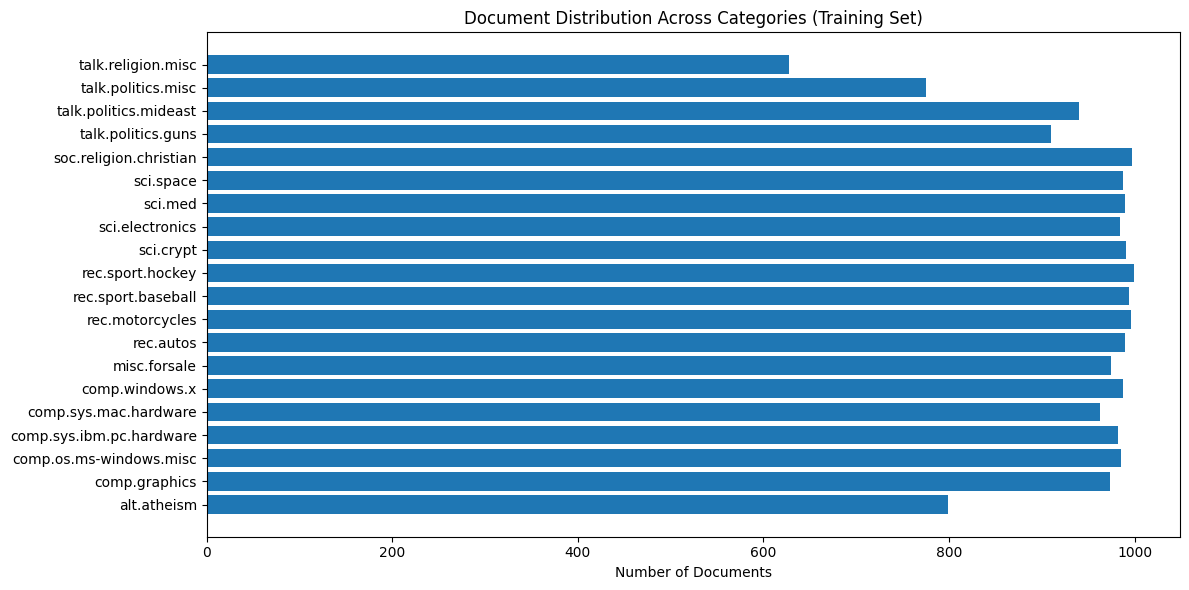

In [ ]:
plt.figure(figsize=(12, 6))
categories = [news_data.target_names[i] for i in sorted(category_counts.keys())]
counts = [category_counts[i] for i in sorted(category_counts.keys())]
plt.barh(categories, counts)
plt.xlabel('Number of Documents')
plt.title('Document Distribution Across Categories (Training Set)')
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame({
    'text': news_data.data,
    'category': [news_data.target_names[t] for t in news_data.target],
    'category_id': news_data.target,
    'word_count': doc_lengths
})
df.head()

,text,category,category_id,word_count
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey,10,157
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware,3,134
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast,17,568
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware,3,538
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware,4,150


#PRE-PROCESSING


In [ ]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)  # remove emails
  text = re.sub(r'http[s]?://\S+', ' ', text) # Remove urls
  text = re.sub(r'[^a-z\s]', ' ', text) # Remove special characters and numbers
  words = text.split()
  return ' '.join(words)

df = pd.DataFrame({'text':news_data.data, 'target':news_data.target})
df['text'] = df['text'].apply(preprocess_text)

df.head(5)

,text,target
0,from mamatha devineni ratnam subject pens fans...,10
1,from matthew b lawson subject which high perfo...,3
2,from hilmi eren subject re armenia says it cou...,17
3,from guy dawson subject re ide vs scsi dma and...,3
4,from alexander samuel mcdiarmid subject driver...,4


In [ ]:
df['text'] = df['text'].apply(word_tokenize)
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopwords])

In [ ]:
stemmer = PorterStemmer()
df['stemmed_text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
df = df[['text', 'stemmed_text', 'target']]

df.head(5)

,text,stemmed_text,target
0,"[mamatha, devineni, ratnam, subject, pens, fan...",mamatha devineni ratnam subject pen fan reacti...,10
1,"[matthew, b, lawson, subject, high, performanc...",matthew b lawson subject high perform vlb vide...,3
2,"[hilmi, eren, subject, armenia, says, could, s...",hilmi eren subject armenia say could shoot tur...,17
3,"[guy, dawson, subject, ide, vs, scsi, dma, det...",guy dawson subject ide vs scsi dma detach orig...,3
4,"[alexander, samuel, mcdiarmid, subject, driver...",alexand samuel mcdiarmid subject driver organ ...,4


#Vocab

In [ ]:
tokens_per_doc = df['stemmed_text'].str.split()
labels = df['target'].tolist()

min_freq = 2
specials = ["<pad>", "<unk>", "<sos>", "<eos>"]
# pad: Padding token
# unk: Unknown token
# sos: Start of sequence
# eos: End of sequence

# -- Build vocab
counter = Counter()
for toks in tokens_per_doc:
  counter.update(toks)

itos = list(specials)
for toks, freq in counter.most_common():
  if freq >= min_freq and toks not in specials:
    itos.append(toks)

stoi = {tok: i for i, tok in enumerate(itos)}
PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"]
SOS_IDX = stoi["<sos>"]
EOS_IDX = stoi["<eos>"]

# Custom collate function to pad sequences in each batch due to document have variable lengths
def collate_batch(batch):
  token_lists, label_list = [], []
  for tokens, label in batch:
    # Convert tokens to indices
    indices = [stoi.get(tok, UNK_IDX) for tok in tokens]
    token_lists.append(torch.tensor(indices, dtype=torch.long))
    label_list.append(label)

  # Pad sequence
  tokens_padded = torch.nn.utils.rnn.pad_sequence(
      token_lists, batch_first=True, padding_value=PAD_IDX
  )
  label_tensor = torch.tensor(label_list, dtype=torch.long)
  return tokens_padded, label_tensor



In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
  def __init__(self, token_lists, labels):
    self.tokens = token_lists
    self.labels = labels

  def __len__(self):
    return len(self.tokens)

  def __getitem__(self, idx):
    return self.tokens[idx], self.labels[idx]

X = tokens_per_doc.tolist()
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, collate_fn=collate_batch)

#Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [ ]:
class Model(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, padding_idx):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
      self.convs = nn.ModuleList([
          nn.Conv1d(
              in_channels=embedding_dim,
              out_channels=n_filters,
              kernel_size=fs
          )
          for fs in filter_sizes
      ])
      self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
      self.dropout = nn.Dropout(dropout)

  def forward(self, text):
    embed = self.embedding(text)
    embed = embed.permute(0,2,1)
    conved = [F.relu(conv(embed)) for conv in self.convs]
    pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conved]
    cat = self.dropout(torch.cat(pooled, dim=1))
    return self.fc(cat)


#Training and Testing

In [ ]:
VOCAB_SIZE = len(stoi)
EMBEDDING_DIM = 128
N_FILTERS = 100
FILTER_SIZE = [3, 4, 5]
OUTPUT_DIM = len(set(y))
DROPOUT = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZE, OUTPUT_DIM, DROPOUT, PAD_IDX).to(device)


In [ ]:
# -- Define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
EPOCHS = 10

# Early stopping
PATIENCE = 3  # Epochs to wait after no improvements
delta = 1e-5  # Minimum improvement to count as improvement
best_state = None
best_test_loss = float('inf')
patience_counter = 0


In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training Loop
for epoch in range(EPOCHS):
  model.train()
  train_loss = 0
  train_correct = 0

  for data, target in train_loader:
    optimizer.zero_grad()
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_correct += (output.argmax(1) == target).sum().item()

  train_loss /= len(train_loader)
  train_acc = train_correct / len(train_loader.dataset)

  # Validation
  model.eval()
  test_loss = 0
  test_correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      test_correct += (output.argmax(1) == target).sum().item()

  test_loss /= len(test_loader)
  test_acc = test_correct / len(test_loader.dataset)

  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

  # Early stopping (To avoid overfitting)
  if test_loss < best_test_loss - delta:
    best_test_loss = test_loss
    best_state = model.state_dict()
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= PATIENCE:
      print("Early stopping triggered.")
      break
if best_state is not None:
  model.load_state_dict(best_state)



Epoch: 1, Train Loss: 2.5723, Train Accuracy: 0.2434 Test Loss: 1.4798, Test Acc: 0.5907
Epoch: 2, Train Loss: 1.5850, Train Accuracy: 0.5306 Test Loss: 1.0351, Test Acc: 0.7154
Epoch: 3, Train Loss: 1.2406, Train Accuracy: 0.6205 Test Loss: 0.8039, Test Acc: 0.7737
Epoch: 4, Train Loss: 0.9952, Train Accuracy: 0.6920 Test Loss: 0.6648, Test Acc: 0.8183
Epoch: 5, Train Loss: 0.7780, Train Accuracy: 0.7588 Test Loss: 0.5753, Test Acc: 0.8329
Epoch: 6, Train Loss: 0.5928, Train Accuracy: 0.8167 Test Loss: 0.5165, Test Acc: 0.8496
Epoch: 7, Train Loss: 0.4523, Train Accuracy: 0.8628 Test Loss: 0.4601, Test Acc: 0.8692
Epoch: 8, Train Loss: 0.3384, Train Accuracy: 0.8994 Test Loss: 0.4538, Test Acc: 0.8735
Epoch: 9, Train Loss: 0.2759, Train Accuracy: 0.9207 Test Loss: 0.4262, Test Acc: 0.8780
Epoch: 10, Train Loss: 0.2181, Train Accuracy: 0.9375 Test Loss: 0.4096, Test Acc: 0.8894


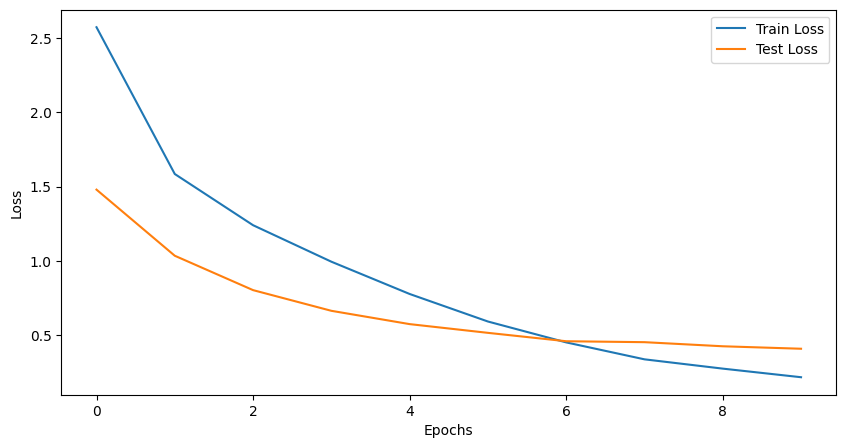

In [ ]:
# Plot Loss Graph
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

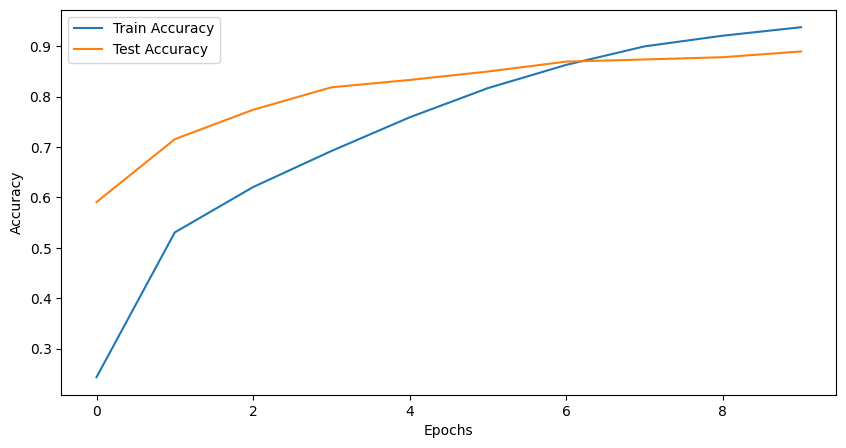

In [ ]:
# Plot Accuracy graph
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

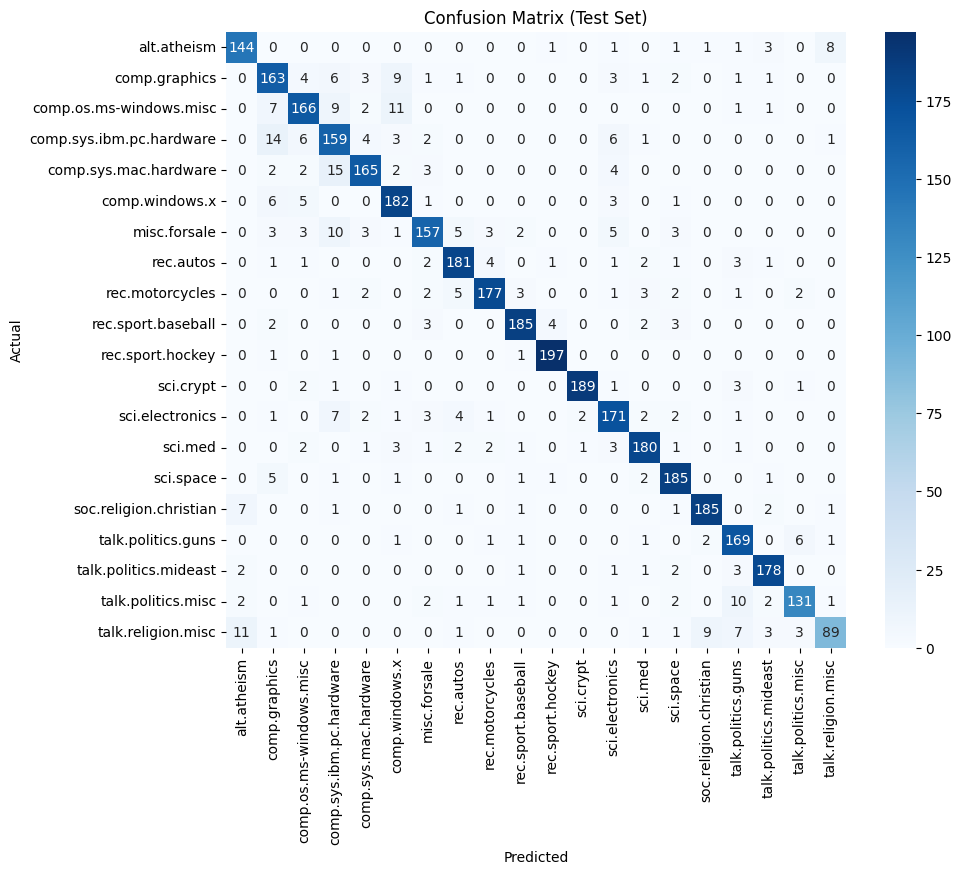

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for the test set
model.eval()
all_targets = []
all_predictions = []
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    predictions = output.argmax(dim=1)
    all_targets.extend(target.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())

# Calculate and plot confusion matrix for the test set
cm_test = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=news_data.target_names, yticklabels=news_data.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Save Model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "CNNModel_news_classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/CNNModel_news_classifier.pth


In [ ]:
!ls -l models/CNNModel_news_classifier.pth


-rw-r--r-- 1 root root 24834440 Oct  5 00:59 models/CNNModel_news_classifier.pth
